# <span style="color:blue">Visualizations</span>

<span style="color:blue">Data is from Kaggle</span>
https://www.kaggle.com/datasets/becksddf/churn-in-telecoms-dataset/data

<span style="color:blue">Imports</span>

In [1]:
# Import modules & packages

# Data manipulation 
import pandas as pd 
import numpy as np 

# Data visualization
import seaborn as sns 
import matplotlib.pyplot as plt 
import plotly.graph_objs as go
import plotly.express as px

# Modeling
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV 
from imblearn.over_sampling import SMOTE,SMOTENC
from sklearn.metrics import f1_score,recall_score,precision_score,confusion_matrix,roc_curve,roc_auc_score,classification_report # performance metrics
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Algorithms for supervised learning methods
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier

# Filtering future warnings
import warnings
warnings.filterwarnings('ignore')

## <span style="color:blue">Load Data</span>

In [2]:
churndata = pd.read_csv('../datasets/clean_churn.csv')

In [3]:
churndata = churndata.drop(columns= 'Unnamed: 0')

In [4]:
churndata.head()

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [5]:
churndata['cost_per_day_call'] = churndata['total_day_charge'] / churndata['total_day_minutes']
churndata['cost_per_intl_call'] = churndata['total_intl_charge'] / churndata['total_intl_minutes']
churndata['cost_per_night_call'] = churndata['total_night_charge'] / churndata['total_night_minutes']
churndata['cost_per_eve_call'] = churndata['total_eve_charge'] / churndata['total_eve_minutes']

night_call_per_min = np.mean(churndata['cost_per_night_call'])
eve_call_per_min = np.mean(churndata['cost_per_eve_call'])
intl_call_per_min = np.mean(churndata['cost_per_intl_call'])
day_call_per_min = np.mean(churndata['cost_per_day_call'])

print(f'Day Cost/Min: ${round(day_call_per_min, 2)}')
print(f'Night Cost/Min: ${round(night_call_per_min, 2)}')
print(f'Eve Cost/Min: ${round(eve_call_per_min, 2)}')
print(f'International Cost/Min: ${round(intl_call_per_min, 2)}')

Day Cost/Min: $0.17
Night Cost/Min: $0.05
Eve Cost/Min: $0.09
International Cost/Min: $0.27


<span style="color:blue">So looking at this we see that if you call a lot through the day or International it costs you more which might flag some concern for users</span>

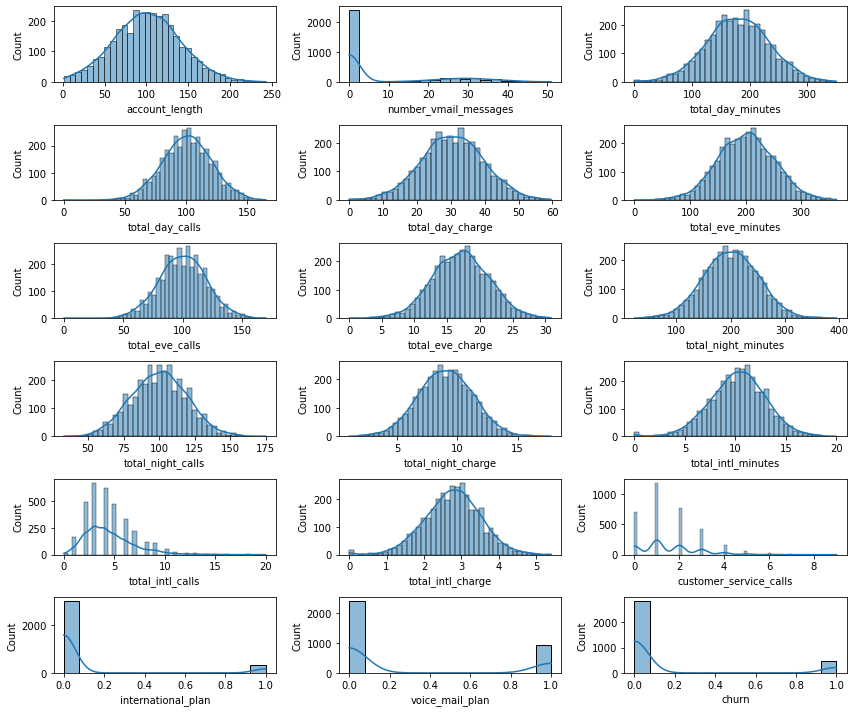

In [6]:
numeric_feat = ['account_length', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge',
'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls',
'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'customer_service_calls',
'international_plan','voice_mail_plan','churn']

# Calculate the number of rows and columns for subplots
nrows = (len(numeric_feat) - 1) // 3 + 1
ncols = min(3, len(numeric_feat))

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 10))

# Flatten axes if necessary
axes = axes.flatten() if nrows > 1 else [axes]

# Plot numeric features
for i, feature in enumerate(numeric_feat):
    ax = axes[i]
    sns.histplot(churndata[feature], kde=True, ax=ax)
    ax.set_xlabel(feature)
    ax.set_ylabel("Count")

# Remove empty subplots
if len(numeric_feat) < nrows * ncols:
    for i in range(len(numeric_feat), nrows * ncols):
        fig.delaxes(axes[i])

# Adjust subplot spacing
fig.tight_layout()

# Display the plot
plt.show()


`Most` <span style="color:blue">features display a normal distribution, indicating a balanced distribution of values.</span>

`Total international calls` <span style="color:blue">shows a right-skewed pattern, suggesting a few customers have significantly more international calls.</span> 

`Customer service calls` <span style="color:blue">exhibits a multimodal distribution with multiple peaks, indicating distinct customer segments with varying levels of interaction with customer service.</span> 

# <span style="color:blue">Lets look at total charges and do that we will need to make a column </span>

<AxesSubplot:>

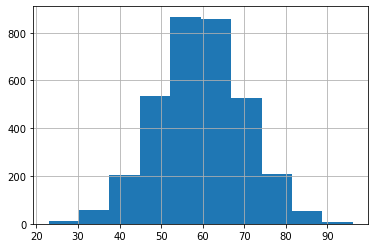

In [7]:
#we will add them together and make a new column for them
churndata['total_charges'] = churndata.total_day_charge + churndata.total_intl_charge + churndata.total_night_charge + churndata.total_eve_charge

churndata['total_charges'].hist()

# <span style="color:blue">Looks like the avg spent amount is $50-70</span>

<AxesSubplot:>

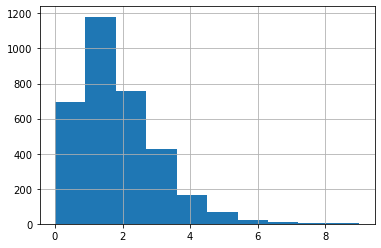

In [8]:
churndata['customer_service_calls'].hist()

# <span style="color:blue">Lets make a data frame with only clients who've churned </span>

# <span style="color:blue">Reminder we changed </span>
<span style="color:green">True & yes<span> `and` <span style="color:red">False & no<span>
   
  1 for <span style="color:green">True & yes<span>
   
  0 for <span style="color:red">False & no<span>

In [9]:
client_churned = churndata[churndata.churn != 0 ]
client_churned.head()

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,...,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,cost_per_day_call,cost_per_intl_call,cost_per_night_call,cost_per_eve_call,total_charges
10,IN,65,0,0,0,129.1,137,21.95,228.5,83,...,12.7,6,3.43,4,1,0.170023,0.270079,0.045019,0.084989,54.20
15,NY,161,0,0,0,332.9,67,56.59,317.8,97,...,5.4,9,1.46,4,1,0.169991,0.270370,0.045019,0.084991,92.29
21,CO,77,0,0,0,62.4,89,10.61,169.9,121,...,5.7,6,1.54,5,1,0.170032,0.270175,0.044990,0.084991,36.02
33,AZ,12,0,0,0,249.6,118,42.43,252.4,119,...,11.8,3,3.19,1,1,0.169992,0.270339,0.045004,0.084984,79.68
41,MD,135,1,1,41,173.1,85,29.43,203.9,107,...,14.6,15,3.94,0,1,0.170017,0.269863,0.045008,0.084993,56.20


In [10]:
not_churned = churndata[churndata.churn != 1 ]
not_churned.head()

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,...,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,cost_per_day_call,cost_per_intl_call,cost_per_night_call,cost_per_eve_call,total_charges
0,KS,128,0,1,25,265.1,110,45.07,197.4,99,...,10.0,3,2.70,1,0,0.170011,0.270000,0.044994,0.085005,75.56
1,OH,107,0,1,26,161.6,123,27.47,195.5,103,...,13.7,3,3.70,1,0,0.169988,0.270073,0.045008,0.085013,59.24
2,NJ,137,0,0,0,243.4,114,41.38,121.2,110,...,12.2,5,3.29,0,0,0.170008,0.269672,0.045018,0.084983,62.29
3,OH,84,1,0,0,299.4,71,50.90,61.9,88,...,6.6,7,1.78,2,0,0.170007,0.269697,0.044997,0.084976,66.80
4,OK,75,1,0,0,166.7,113,28.34,148.3,122,...,10.1,3,2.73,3,0,0.170006,0.270297,0.044997,0.085030,52.09


In [11]:
client_churned['customer_service_calls'].value_counts()

1    122
0     92
2     87
4     76
3     44
5     40
6     14
7      5
9      2
8      1
Name: customer_service_calls, dtype: int64

In [12]:
not_churned['customer_service_calls'].value_counts()

1    1059
2     672
0     605
3     385
4      90
5      26
6       8
7       4
8       1
Name: customer_service_calls, dtype: int64

<span style="color:blue">Churn Rate for 1: 122 ≈ 10.3%</span>

<span style="color:blue">Churn Rate for 2: 87 ≈ 11.5%</span>

<span style="color:blue">Churn Rate for 0: 92 ≈ 13.2%</span>

<span style="color:blue">Churn Rate for 4: 76 ≈ 45.7%</span>

<span style="color:blue">Churn Rate for 3: 44 ≈ 10.2%</span>

<span style="color:blue">Churn Rate for 5: 40 ≈ 60.6%</span>

<span style="color:blue">Churn Rate for 6: 14 ≈ 63.6%</span>

<span style="color:blue">Churn Rate for 7: 5 ≈ 55.6%</span>

<span style="color:blue">Churn Rate for 9: 2 = 100%</span>

<span style="color:blue">Churn Rate for 8: 1 = 50%</span>

it appers that greater proportion of clients will churn after 4 or 5 calls

# <span style="color:blue">How does SyriaTel Churn look to its competitors</span>

<span style="color:blue">All of this is via web search</span>

<span style="color:blue">T-Mobile US had a churn rate of 0.77%</span>

<span style="color:blue">AT&T's churn rate was 0.79% in the recent quarter.</span>

<span style="color:blue">Verizon's wireless retail churn rate stood at 1.63%</span>

<span style="color:blue">Jio continued to lead industry's net subscriber addition with 9.2 million in the quarter. Monthly churn reduced to 1.8%</span>

<span style="color:blue">SyriaTel 15%</span>

In [13]:
top_telecom = {
    'Nippon': 0.67,
    'T-Mobile': 0.98,
    'AT&T': 0.69,
    'Verizon': 1.03,
    'SyriaTel': 14.5
}

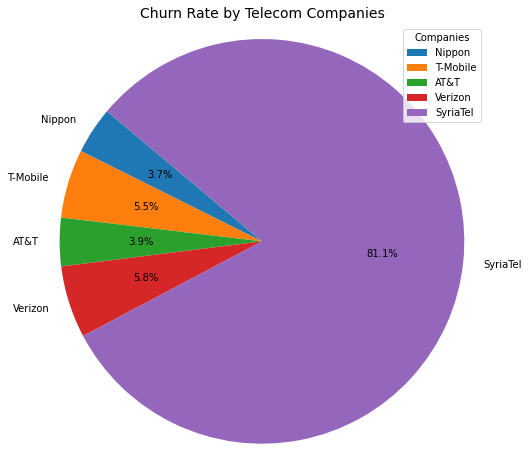

In [14]:
plt.figure(figsize=(8, 8))
plt.pie(top_telecom.values(), labels=top_telecom.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Churn Rate by Telecom Companies', size=14)
plt.legend(top_telecom.keys(), title='Companies', loc='best')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()